# Titration of fusogen reveals optimal dosage for exporter-dependent RNA delivery

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/flow_VSVG_titration"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

In [4]:
infile = "../preprocessed_data/flow_data/flow_VSVG_titration_summary.csv"

df_raw = pd.read_csv(infile, index_col=0)

print(df_raw.shape)
df_raw

(21, 17)


,Plate Number,Well Number,Condition Name,Exporter?,Cargo?,Export Tag?,Fusogen?,Fusogen_mass_ng,Total Ungated Events,Putative Cell Events,% Putative Cells in Total Events,Singlet Gated Events,% Singlets in Putative Cells,GFP-A Events in Singlet POI,% of GFP-A Events in Singlet POI,mCherry-A Events in GFP-A POI,% of mCherry-A Events in GFP-A POI
0,1,A1,allDNA_CreMS2_VSVG_1250ng,-,+,+,+,1250,15894,3957,24.896187,3821,96.563053,3706,96.990317,579,15.623314
2,1,A3,allDNA_CreMS2,-,+,+,-,0,24369,10494,43.062908,9880,94.149038,9600,97.165992,58,0.604167
5,1,A6,allDNA_CreMS2_VSVG_600ng,-,+,+,+,600,15502,4583,29.563927,4431,96.683395,4274,96.456782,703,16.448292
8,1,A9,allDNA_CreMS2_VSVG_100ng,-,+,+,+,100,32301,14914,46.171945,14102,94.555451,13664,96.894058,247,1.807670
12,1,B1,allDNA_EPN24_CreMS2_VSVG_1250ng,+,+,+,+,1250,14879,3231,21.715169,3131,96.904983,3036,96.965826,788,25.955204
13,1,B2,allDNA_EPN24_Cre_VSVG_1250ng,+,+,-,+,1250,15763,3486,22.115080,3356,96.270797,3226,96.126341,999,30.967142
14,1,B3,allDNA_EPN24_CreMS2,+,+,+,-,0,29885,13384,44.785009,12696,94.859534,12264,96.597353,68,0.554468
15,1,B4,allDNA_EPN24_Cre,+,+,-,-,0,27385,11802,43.096586,11246,95.288934,10880,96.745510,43,0.395221
18,1,B7,allDNA_EPN24_CreMS2_VSVG_600ng,+,+,+,+,600,13124,2062,15.711673,1986,96.314258,1889,95.115811,972,51.455797
19,1,B8,allDNA_EPN24_Cre_VSVG_600ng,+,+,-,+,600,14648,2913,19.886674,2827,97.047717,2698,95.436859,1095,40.585619


# Preprocess data

In [5]:
# Sort values by fusogen mass (to ensure points are plotted in order)
df_raw = df_raw.sort_values(by="Fusogen_mass_ng", ascending=True)

In [6]:
# Substitute pseudocount for zero masses (for plotting on log scale)
PSEUDOCOUNT = 5
df_raw["Fusogen_mass_ng_pseudocount"] = df_raw["Fusogen_mass_ng"].replace(0, PSEUDOCOUNT)

# Plot VSVG titration: delivery with varying VSVG plasmid

In [7]:
# Set colors
colors = ["#6b52a2", "#fbb885", "#8a8c8f"]

In [8]:
# Select data

# All components (exporter, fusogen, packaging signal)
conditions1 = ["allDNA_EPN24_CreMS2_VSVG_1250ng",
               "allDNA_EPN24_CreMS2_VSVG_600ng",
               "allDNA_EPN24_CreMS2_VSVG_100ng",
               "allDNA_EPN24_CreMS2_VSVG_50ng",
               "allDNA_EPN24_CreMS2_VSVG_25ng",
               "allDNA_EPN24_CreMS2_VSVG_10ng",
               "allDNA_EPN24_CreMS2"]
selector = df_raw["Condition Name"].isin(conditions1)
data1 = df_raw.loc[selector]
x1 = data1["Fusogen_mass_ng_pseudocount"]
y1 = data1["% of mCherry-A Events in GFP-A POI"]

# No exporter
conditions2 = ["allDNA_CreMS2_VSVG_1250ng",
               "allDNA_CreMS2_VSVG_600ng",
               "allDNA_CreMS2_VSVG_100ng",
               "allDNA_CreMS2_VSVG_50ng",
               "allDNA_CreMS2_VSVG_25ng",
               "allDNA_CreMS2_VSVG_10ng",
               "allDNA_CreMS2"]
selector = df_raw["Condition Name"].isin(conditions2)
data2 = df_raw.loc[selector]
x2 = data2["Fusogen_mass_ng_pseudocount"]
y2 = data2["% of mCherry-A Events in GFP-A POI"]

# No packaging signal
conditions3 = ["allDNA_EPN24_Cre_VSVG_1250ng",
               "allDNA_EPN24_Cre_VSVG_600ng",
               "allDNA_EPN24_Cre_VSVG_100ng",
               "allDNA_EPN24_Cre_VSVG_50ng",
               "allDNA_EPN24_Cre_VSVG_25ng",
               "allDNA_EPN24_Cre_VSVG_10ng",
               "allDNA_EPN24_Cre"]
selector = df_raw["Condition Name"].isin(conditions3)
data3 = df_raw.loc[selector]
x3 = data3["Fusogen_mass_ng_pseudocount"]
y3 = data3["% of mCherry-A Events in GFP-A POI"]

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


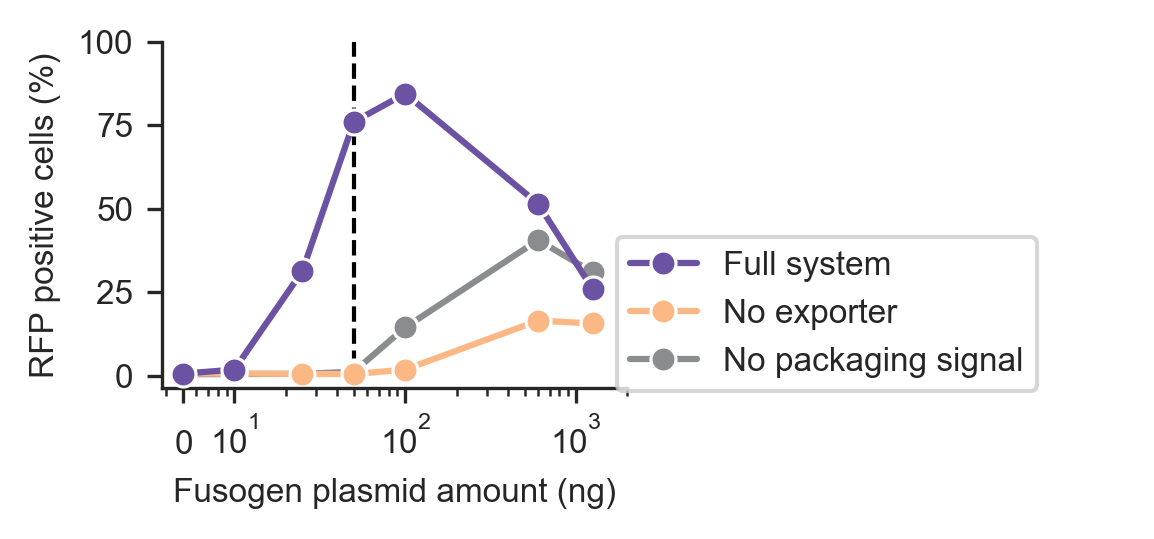

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(2,1.5))

sns.lineplot(ax=ax, x=x1, y=y1, marker="o", color=colors[0], label="Full system", legend=False, zorder=3)
sns.lineplot(ax=ax, x=x2, y=y2, marker="o", color=colors[1], label="No exporter", legend=False, zorder=2)
sns.lineplot(ax=ax, x=x3, y=y3, marker="o", color=colors[2], label="No packaging signal", legend=False, zorder=1)

ax.set_xscale("log")

ax.set_xlim(right=2000)
ax.set_ylim(top=100)

ax.set_xlabel("Fusogen plasmid amount (ng)")
ax.set_ylabel("RFP positive cells (%)")

fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))

xticks = [5, 10, 100, 1000]
xticklabels = [r"$0$", r"$10^1$", "$10^2$", "$10^3$"]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, va="bottom")
ax.tick_params(axis='x', which='major', pad=14)

ax.axvline(50, ls="--", color="k", lw=1, zorder=-1)

sns.despine()

save_figure(fig, "fusogen_vs_delivery_titration")